# Week 06 - Decision Tree

## Data Preparation

- Reformat categorical columns (status, home, marital, records, and job) by mapping with appropriate values.
- Replace the maximum value of income, assests, and debt columns with NaNs.
- Replace the NaNs in the dataframe with 0 (will be shown in the next lesson).
- Extract only those rows in the column status who are either ok or default as value.
- Split the data in a two-step process which finally leads to the distribution of 60% train, 20% validation, and 20% test sets with random seed to 11.
- Prepare target variable status by converting it from categorical to binary, where 0 represents ok and 1 represents default.
- Finally delete the target variable from the train/val/test dataframe.

In [233]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

%matplotlib inline

In [234]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

df = pd.read_csv(url)
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [235]:
df.columns = df.columns.str.lower()

In [236]:
df.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In [237]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [238]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [239]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [240]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [241]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [242]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=11)

In [243]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [244]:
y_train = (df_train.status == 'default').astype('int')
y_val = (df_val.status == 'default').astype('int')
y_test = (df_test.status == 'default').astype('int')

In [245]:
del df_train['status']
del df_val['status']
del df_test['status']

## Decision Trees

Decision Trees are powerful algorithms, capable of fitting complex datasets. The decision trees make predictions based on the bunch of if/else statements by splitting a node into two or more sub-nodes.

With versatility, the decision tree is also prone to overfitting. One of the reason why this algorithm often overfits because of its depth. It tends to memorize all the patterns in the train data but struggle to performs well on the unseen data (validation or test set).

To overcome with overfitting problem, we can reduce the complexity of the algorithm by reducing the depth size.

The decision tree with only a single depth is called decision stump and it only has one split from the root.

Classes, functions, and methods:

- DecisionTreeClassifier: classification model from sklearn.tree class.
- max_depth: hyperparameter to control the depth of decision tree algorithm.
- export_text: method from sklearn.tree class to display the text report showing the rules of a decision tree.

Note: we have already covered DictVectorizer in session 3 and roc_auc_score in session 4 respectively.

In [246]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [247]:
xi = df_train.iloc[0].to_dict()

In [248]:
assess_risk(xi)

'default'

In [249]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [250]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [251]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [252]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6447840375586855

In [253]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

In [254]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [255]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7012100105368865
val: 0.6759624413145541


In [256]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



## Decision tree learning algorithm

This lesson first reviews the topics learned in previous lesson about training a decision tress using sklearn, how to handle the model not generalizing due to overfitting of the data.

In this lesson, we learn about how to best split a decision tree and different classification criteria that can be used to split a tree. We dive deep using an example and splitting the tree using misclassification criteria. Additionally, different stopping criteria to break the iterative tree split criteria are discussed.

- structure of a decision tree: nodes & leaves
- depth of a decision tree & levels
- rules & conditions, thresholds
- misclassification rate
- impurity criteria (i.e. MSE)
- decision trees can be used to solve regression problems


In [257]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [258]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
4,5000,ok
3,5000,ok
0,8000,default
6,9000,ok


In [259]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [260]:
T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
print(df_left.status.value_counts(normalize=True))
display(df_right)
print(df_left.status.value_counts(normalize=True))

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


In [261]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print()


0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64



In [262]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [263]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
3,5000,1000,ok
2,0,1000,default
5,4000,1000,ok
4,5000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [264]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [265]:
for feature, Ts in thresholds.items():
    print('#####################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('#####################')


#####################
assets
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

#####################
#####################
debt
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64

#####################


## Decision trees parameter tuning

In this lesson, we will discuss about different parameters present to control a Decision Tree (DT). Two features, max_depth and min_samples_leaf have a greater importance than other parameters. We will further see how we first tune max_depth parameter and then move to tuning other parameters will help. Finally, a dataframe is created with all possible combinations of max_depth, min_sample_leaf and the auc score corresponding to them. These results are visualized using a heatmap by pivoting the dataframe to easily determine the best possible max_depth and min_samples_leaf combination. Finally, the DT is retrained using the identified parameter combination. DT so trained is viewed as a tree diagram.

- selecting max_depth
- selecting min_samples_leaf

In [266]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.607
   2 -> 0.676
   3 -> 0.748
   4 -> 0.773
   5 -> 0.770
   6 -> 0.777
  10 -> 0.716
  15 -> 0.669
  20 -> 0.661
None -> 0.654


In [267]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [268]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [269]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.773  0.770  0.777
5                 0.773  0.771  0.778
10                0.773  0.769  0.776
15                0.773  0.779  0.783
20                0.766  0.784  0.792
100               0.767  0.780  0.783
200               0.764  0.772  0.781
500               0.697  0.697  0.697

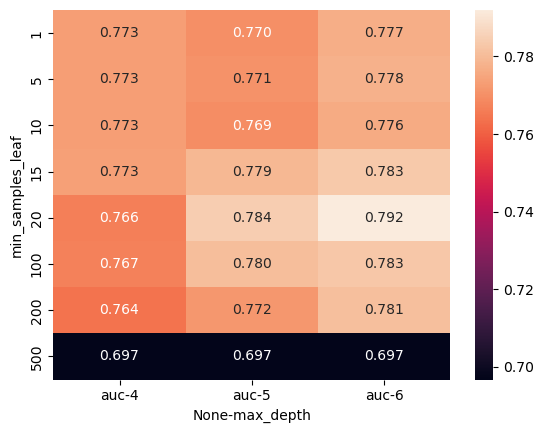

In [270]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")
plt.show()

In [271]:
# dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=20)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=20)

In [272]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- assets <= 4250.00
|   |   |   |   |--- income <= 20.00
|   |   |   |   |   |--- seniority <= 1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- seniority >  1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- income >  20.00
|   |   |   |   |   |--- expenses <= 71.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- expenses >  71.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  4250.00
|   |   |   |   |--- debt <= 1550.00
|   |   |   |   |   |--- seniority <= 2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- seniority >  2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- debt >  1550.00
|   |   |   |   |   |--- class: 1
|   |   |--- income >  74.50
|   |   |   |--- seniority <= 5.50
|   |   |   |   |--- amount <= 1330.00
|   |   |   |   |   |--- assets <= 3326.00
|   |   |   |   |   |   |--- clas

## Ensembles and random forest

Random Forest is an example of ensemble learning where each model is a decision tree and their predictions are aggregated to identify the most popular result. Random forest only select a random subset of features from the original data to make predictions.

In random forest the decision trees are trained independent to each other.

Classes, functions, and methods:
- from sklearn.ensemble import RandomForestClassifier: random forest classifier from sklearn ensemble class.
- plt.plot(x, y): draw line plot for the values of y against x values.
- bootstrapping: training on a subset of the observations

==

- Board of experts
- Ensembling models
- Random forest - ensembling decision trees
- Tuning random forest

In [273]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [274]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

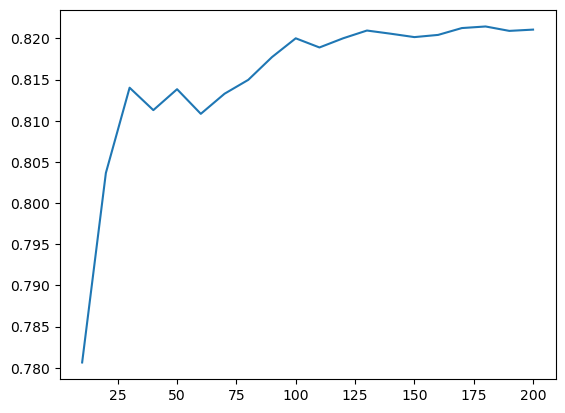

In [275]:
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.show()

In [276]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [277]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.812131
1,5,20,0.812718
2,5,30,0.816568
3,5,40,0.813714
4,5,50,0.813826


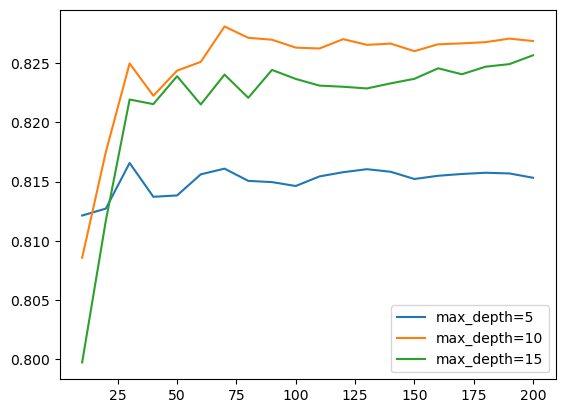

In [278]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()
plt.show()

In [279]:
max_depth = 10

In [280]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [281]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

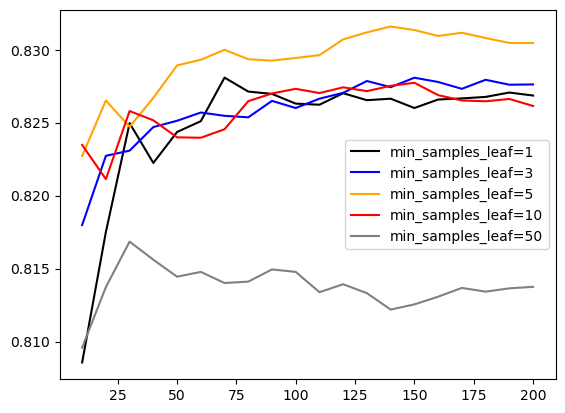

In [282]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()
plt.show()

In [283]:
min_samples_leaf = 5

In [284]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=200,
                       random_state=1)

Other useful parametes:

1. max_features
2. bootstrap

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## Gradient Boosting and XGBoost

- Gradient boosting vs random forest
- Installing XGBoost
- Training the first model
- Performance monitoring
- Parsing xgboost's monitoring output

XGBoost has various tunable parameters but the three most important ones are:

- eta (default=0.3)
    - It is also called learning_rate and is used to prevent overfitting by regularizing the weights of new features in each boosting step. range: [0, 1]
- max_depth (default=6)
    - Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. range: [0, inf]
- min_child_weight (default=1)
    - Minimum number of samples in leaf node. range: [0, inf]

For XGBoost models, there are other ways of finding the best parameters as well but the one we implement in the notebook follows the sequence of:

1. First find the best value for eta
2. Second, find the best value for max_depth
3. Third, find the best value for min_child_weight

Other useful parameter are:
- subsample (default=1)
    - Subsample ratio of the training instances. Setting it to 0.5 means that model would randomly sample half of the training data prior to growing trees. range: (0, 1]
- colsample_bytree (default=1)
    - This is similar to random forest, where each tree is made with the subset of randomly choosen features.
- lambda (default=1)
    - Also called reg_lambda. L2 regularization term on weights. Increasing this value will make model more conservative.
- alpha (default=0)
    - Also called reg_alpha. L1 regularization term on weights. Increasing this value will make model more conservative.

In [285]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [286]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [287]:
y_pred = model.predict(dval)

In [288]:
roc_auc_score(y_val, y_pred)

0.8155915492957747

In [289]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [290]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [291]:
s = output.stdout

In [292]:
print(s[:200])

[0]	train-auc:0.86520	val-auc:0.78772
[5]	train-auc:0.92817	val-auc:0.81711
[10]	train-auc:0.94879	val-auc:0.81533
[15]	train-auc:0.96114	val-auc:0.81577
[20]	train-auc:0.96818	val-auc:0.81951
[25]	tr


In [293]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [294]:
df_score = parse_xgb_output(output)

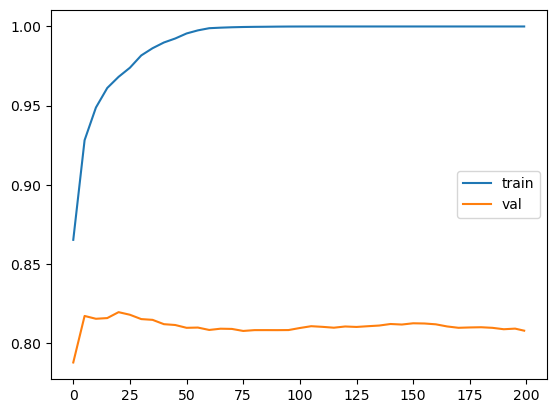

In [295]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()
plt.show()

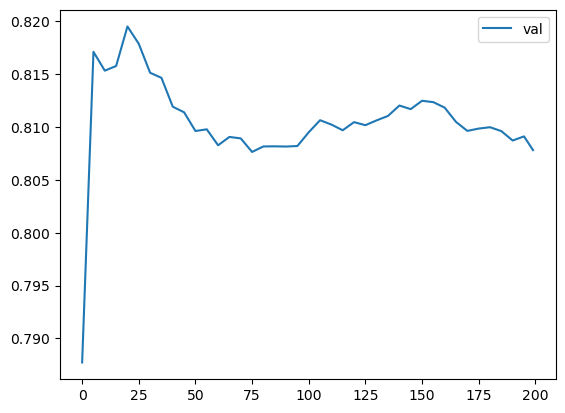

In [296]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()
plt.show()

### XGBoost Parameter Tuning

In [297]:
scores = {}

In [298]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [299]:
scores = {}

In [300]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [301]:
scores = {}

In [302]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)


In [303]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

In [304]:
# del scores['max_depth=10']

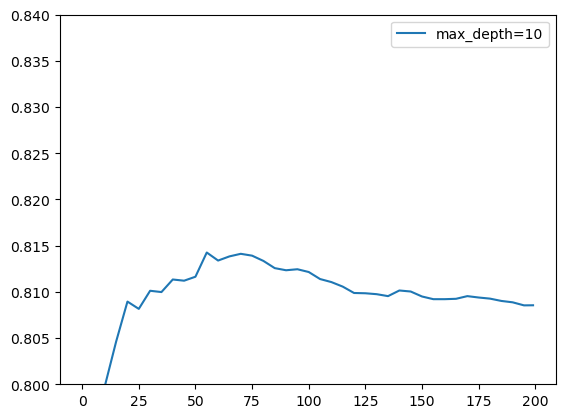

In [305]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.8, 0.84)
plt.legend()
plt.show()

In [306]:
scores = {}

In [307]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [308]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

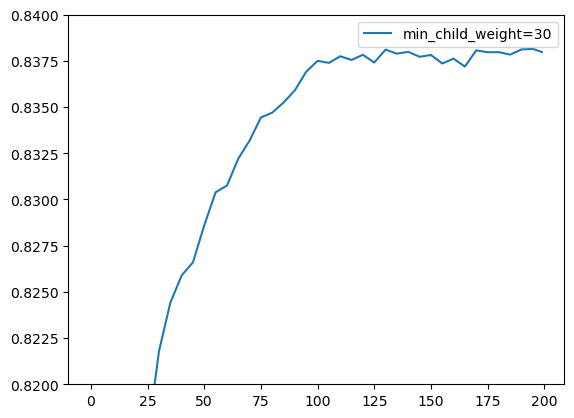

In [309]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.82, 0.84)
plt.legend()
plt.show()

In [310]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

Other parameters: https://xgboost.readthedocs.io/en/latest/parameter.html

Useful ones:
- subsample and colsample_bytree
- lambda and alpha

## Selecting the Final Model
- Choosing between xgboost, random forest and decision tree
- Training the final model
- Saving the model

In [311]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [312]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7875070422535211

In [313]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [314]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8276197183098591

In [315]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [316]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8335727699530517

In [317]:
df_full_train = df_full_train.reset_index(drop=True)

In [318]:
y_full_train = (df_full_train.status == 'default').astype(int).values

In [319]:
del df_full_train['status']

In [226]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [322]:
features = list(dv.get_feature_names_out())

dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=features)

dtest = xgb.DMatrix(X_test, feature_names=features)

In [323]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [324]:
y_pred = model.predict(dtest)

In [325]:
roc_auc_score(y_test, y_pred)

0.8289367577342261

## Summary

- Decision trees learn if-then-else rules from data.
- Finding the best split: select the least impure split. This algorithm can overfit, that's why we control it by limiting the max depth and the size of the group.
- Random forest is a way of combininig multiple decision trees. It should have a diverse set of models to make good predictions.
- Gradient boosting trains model sequentially: each model tries to fix errors of the previous model. XGBoost is an implementation of gradient boosting.

## Explore More
- For this dataset we didn't do EDA or feature engineering. You can do it to get more insights into the problem.
- For random forest, there are more parameters that we can tune. Check max_features and bootstrap.
- There's a variation of random forest caled "extremely randomized trees", or "extra trees". Instead of selecting the best split among all possible thresholds, it selects a few thresholds randomly and picks the best one among them. Because of that extra trees never overfit. In Scikit-Learn, they are implemented in ExtraTreesClassifier. Try it for this project.
- XGBoost can deal with NAs - we don't have to do fillna for it. Check if not filling NA's help improve performance.
- Experiment with other XGBoost parameters: subsample and colsample_bytree.
- When selecting the best split, decision trees find the most useful features. This information can be used for understanding which features are more important than otheres. See example here for random forest (it's the same for plain decision trees) and for xgboost
- Trees can also be used for solving the regression problems: check DecisionTreeRegressor, RandomForestRegressor and the objective=reg:squarederror parameter for XGBoost.